## 本記事本學習目標:

- 運用pandas架構交通事故dataframe，並且做資料解析
- 運用matplotlib結合dataframe創建簡易圖表
- 運用pydeck結合dataframe創建3D地圖

## 事前準備

#### 安裝pandas,matplotlob,pydeck
> pip install pandas<br>
> pip install matplotlib<br>
> pip install pydeck<br>
#### 將Mapbox之token設定成環境變數
> export MAPBOX_API_KEY = "{YOUR MAPBOX API KEY}"

#### 將matplotlib預設字體設定成支援中文的字體

## 流程

載入模組

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pydeck as pdk
import math

讀取CSV檔

In [2]:
data = pd.read_csv("NPA_TMA1.csv")
data = data.dropna()
gps = pd.read_csv('TW_City_GPS.csv')
gps = gps.set_index('city')

分割日期與時間

In [3]:
data[['日期','時間']]  = data['發生時間'].str.split(' ', 1, expand=True)

分割死亡與受傷人數

In [4]:
data[['死亡人數','受傷人數']] = data['死亡受傷人數'].str.split(';', 1, expand=True).infer_objects()

將資料內“死亡”及“受傷”文字去除，並使用astype()轉換為int型態

In [5]:
data['死亡人數'] = data['死亡人數'].str.strip('死亡').astype(int)
data['受傷人數'] = data['受傷人數'].str.strip('受傷').astype(int)

擷取發生地縣市

In [6]:
data['縣市'] = data['發生地點'].str[0:3].astype(str)
data["城市"] = data['縣市'].str.strip('縣').str.strip('市').astype(str)

將整理後的資料擷取出來

In [7]:
people_count = data[['城市','死亡人數','受傷人數']].copy()
freq = people_count.groupby(['城市']).sum()
freq[0:6]
freq['緯度'] = ""
freq['經度'] = ""
for city in freq.index.to_list():
    if city in gps.index.to_list():
        freq['緯度'][city]  = gps.loc[city,'lat'].copy()
        freq['經度'][city]  = gps.loc[city,'lng'].copy()


<ipython-input-7-47bac64d6724>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq['緯度'][city]  = gps.loc[city,'lat'].copy()
<ipython-input-7-47bac64d6724>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq['經度'][city]  = gps.loc[city,'lng'].copy()


統計各縣市死亡及受傷人數

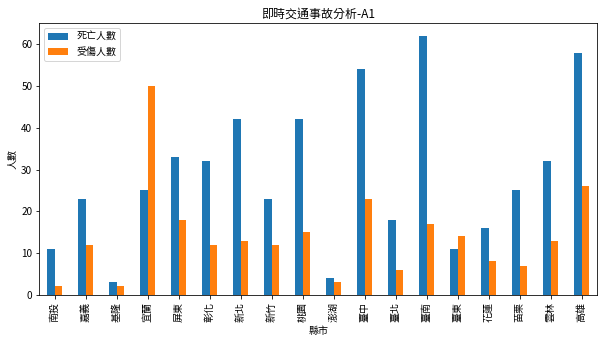

In [8]:
chart = freq.plot(kind='bar',  #圖表類型
    title='即時交通事故分析-A1',  #圖表標題
    xlabel='縣市',  #x軸說明文字
    ylabel='人數',  #y軸說明文字
    legend=True,  # 是否顯示圖例
    figsize=(10, 5))  # 圖表大小
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC'] #設定支援中文的字體
plt.show()

設定pydeck柱狀圖圖層

In [9]:
column_layer = pdk.Layer(
    "ColumnLayer",
    freq,
    get_position=['經度', '緯度'],
    get_elevation="死亡人數",
    elevation_scale=1000,
    radius=750,
    get_fill_color=[100,10,10],
    pickable=True,
    auto_highlight=True,
)

設定pydeck地圖圖層

In [10]:
view_state = pdk.ViewState(latitude=23.5, longitude=120.5, zoom=7, bearing=0, pitch=45, max_room=7, min_room=7)

執行渲染及輸出

In [11]:
r = pdk.Deck(layers=[column_layer], initial_view_state=view_state, tooltip={"text": '死亡人數: {死亡人數} '},)
r.show()
#r.to_html("grid_layer.html") #輸出成網頁

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{"initialViewState": {"bea…